# Analýza sentimentu textu pomocí LSTM

Tento notebook implementuje model pro automatickou analýzu sentimentu textů pomocí hluboké neuronové sítě (LSTM).

**Cíl projektu:** Binární klasifikace sentimentu (pozitivní/negativní) na datasetu Sentiment140.

## Obsah
1. Nastavení prostředí a import knihoven
2. Načtení a explorace dat
3. Preprocessing textu
4. Tokenizace a příprava dat
5. Vytvoření LSTM modelu
6. Trénování modelu
7. Vyhodnocení a vizualizace
8. Inference pro nové texty

## 1. Nastavení prostředí

Nejprve ověříme připojení ke Google Colab a zkontrolujeme dostupný hardware (GPU).

In [2]:
# Ověření prostředí - zjistíme, jestli běžíme na Colab a jaký máme hardware
import sys

# Kontrola, zda běžíme v Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Běžíme v Google Colab")
except ImportError:
    IN_COLAB = False
    print("⚠️ Neběžíme v Colab - používáme lokální prostředí")

# Kontrola dostupného GPU
import tensorflow as tf
print(f"\n📦 TensorFlow verze: {tf.__version__}")
print(f"🐍 Python verze: {sys.version}")

# Kontrola GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"🚀 GPU dostupné: {len(gpus)}")
    for gpu in gpus:
        print(f"   - {gpu.name}")
else:
    print("💻 GPU není dostupné - použijeme CPU")

✅ Běžíme v Google Colab

📦 TensorFlow verze: 2.19.0
🐍 Python verze: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
💻 GPU není dostupné - použijeme CPU


### Import knihoven

Nyní naimportujeme všechny potřebné knihovny:
- **TensorFlow/Keras** - framework pro deep learning
- **NumPy** - numerické výpočty
- **Pandas** - práce s daty
- **scikit-learn** - metriky a rozdělení dat
- **Matplotlib** - vizualizace

In [3]:
# Import všech potřebných knihoven
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # pro čištění textu (regulární výrazy)

# TensorFlow a Keras komponenty
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn pro metriky a rozdělení dat
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Nastavení pro reprodukovatelnost výsledků
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Všechny knihovny úspěšně naimportovány!")

✅ Všechny knihovny úspěšně naimportovány!


## 2. Načtení dat

Dataset **Sentiment140** obsahuje 1.6 milionu tweetů označených jako pozitivní (4) nebo negativní (0).

Stáhneme ho z Kaggle pomocí knihovny `kagglehub`.

In [4]:
# Stažení datasetu Sentiment140 z Kaggle
# Při prvním spuštění může být potřeba autentizace

import kagglehub

# Stažení datasetu - kagglehub ho uloží do cache
print("📥 Stahuji dataset Sentiment140...")
dataset_path = kagglehub.dataset_download("kazanova/sentiment140")
print(f"✅ Dataset stažen do: {dataset_path}")

📥 Stahuji dataset Sentiment140...
Using Colab cache for faster access to the 'sentiment140' dataset.
✅ Dataset stažen do: /kaggle/input/sentiment140


In [5]:
# Načtení datasetu do pandas DataFrame
import os

# Najdeme CSV soubor v datasetu
csv_file = os.path.join(dataset_path, "training.1600000.processed.noemoticon.csv")

# Dataset nemá hlavičky, musíme je definovat ručně
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']

# Načtení CSV - encoding je latin-1 (ISO-8859-1)
print("📂 Načítám data do paměti...")
df = pd.read_csv(csv_file, encoding='latin-1', names=column_names)

print(f"✅ Načteno {len(df):,} záznamů")
print(f"📊 Sloupce: {list(df.columns)}")

📂 Načítám data do paměti...
✅ Načteno 1,600,000 záznamů
📊 Sloupce: ['target', 'id', 'date', 'flag', 'user', 'text']


### Explorace dat

Podíváme se, jak data vypadají — prvních pár řádků, rozložení sentimentu, příklady textů.

In [6]:
# Zobrazení prvních 5 řádků
print("📋 Prvních 5 záznamů:")
df.head()



📋 Prvních 5 záznamů:


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


📊 Rozložení sentimentu:
target
0    800000
4    800000
Name: count, dtype: int64


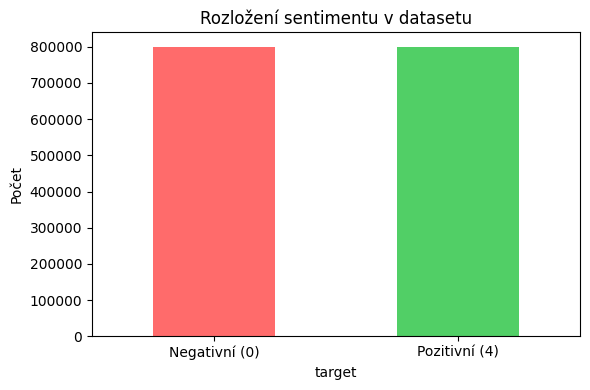

In [7]:
# Rozložení sentimentu v datasetu
print("📊 Rozložení sentimentu:")
print(df['target'].value_counts())

# Vizualizace
fig, ax = plt.subplots(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', ax=ax, color=['#ff6b6b', '#51cf66'])
ax.set_xticklabels(['Negativní (0)', 'Pozitivní (4)'], rotation=0)
ax.set_ylabel('Počet')
ax.set_title('Rozložení sentimentu v datasetu')
plt.tight_layout()
plt.show()

In [8]:
# Příklady negativních a pozitivních tweetů
print("😠 Příklady NEGATIVNÍCH tweetů:")
for text in df[df['target'] == 0]['text'].head(3):
    print(f"  • {text[:100]}...")

print("\n😊 Příklady POZITIVNÍCH tweetů:")
for text in df[df['target'] == 4]['text'].head(3):
    print(f"  • {text[:100]}...")

😠 Příklady NEGATIVNÍCH tweetů:
  • @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third D...
  • is upset that he can't update his Facebook by texting it... and might cry as a result  School today ...
  • @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds...

😊 Příklady POZITIVNÍCH tweetů:
  • I LOVE @Health4UandPets u guys r the best!! ...
  • im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!...
  • @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in th...


## 3. Preprocessing textu

Tweety obsahují mnoho "šumu", který model nepotřebuje:
- **@mentions** — uživatelská jména
- **URL odkazy** — http://...
- **Speciální znaky** — emotikony, HTML entity
- **Velká písmena** — převedeme na malá

Vytvoříme funkci pro čištění textu.

In [9]:
def clean_text(text):
    """
    Vyčistí tweet od šumu.
    
    Args:
        text: Původní text tweetu
    Returns:
        Vyčištěný text
    """
    # Převod na malá písmena
    text = text.lower()
    
    # Odstranění @mentions (např. @user123)
    text = re.sub(r'@\w+', '', text)
    
    # Odstranění URL odkazů
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Odstranění HTML entit (např. &amp; &lt;)
    text = re.sub(r'&\w+;', '', text)
    
    # Odstranění speciálních znaků a číslic (ponecháme jen písmena a mezery)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Odstranění nadbytečných mezer
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test funkce na příkladu
test_tweet = "@user123 I love this movie!!! 😊 Check it out: http://example.com #awesome"
print(f"Původní:   '{test_tweet}'")
print(f"Vyčištěný: '{clean_text(test_tweet)}'")

Původní:   '@user123 I love this movie!!! 😊 Check it out: http://example.com #awesome'
Vyčištěný: 'i love this movie check it out awesome'


In [10]:
# Aplikace čištění na celý dataset
# POZOR: Toto může trvat několik minut na 1.6M záznamech!

print("🧹 Čistím texty...")
df['clean_text'] = df['text'].apply(clean_text)
print("✅ Hotovo!")

# Ukázka před/po
print("\n📊 Ukázka vyčištěných textů:")
for i in range(3):
    print(f"\nPůvodní:   {df['text'].iloc[i][:80]}...")
    print(f"Vyčištěný: {df['clean_text'].iloc[i][:80]}...")

🧹 Čistím texty...
✅ Hotovo!

📊 Ukázka vyčištěných textů:

Původní:   @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got D...
Vyčištěný: a thats a bummer you shoulda got david carr of third day to do it d...

Původní:   is upset that he can't update his Facebook by texting it... and might cry as a r...
Vyčištěný: is upset that he cant update his facebook by texting it and might cry as a resul...

Původní:   @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out ...
Vyčištěný: i dived many times for the ball managed to save the rest go out of bounds...


In [11]:
# Převod sentimentu na binární hodnoty (0 = negativní, 1 = pozitivní)
# Původně: 0 = negativní, 4 = pozitivní
# Nově:    0 = negativní, 1 = pozitivní

df['sentiment'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

print("📊 Nové rozložení sentimentu:")
print(df['sentiment'].value_counts())
print(f"\n0 = Negativní, 1 = Pozitivní")

📊 Nové rozložení sentimentu:
sentiment
0    800000
1    800000
Name: count, dtype: int64

0 = Negativní, 1 = Pozitivní


## 4. Tokenizace a příprava dat

Neuronová síť nerozumí textu — potřebuje čísla. Proto musíme:

1. **Tokenizace** — každé slovo dostane unikátní číslo (index)
2. **Padding** — všechny sekvence musí mít stejnou délku

Příklad: `"i love this"` → `[1, 45, 23]` → `[1, 45, 23, 0, 0, 0, ...]`

In [12]:
# Hyperparametry pro tokenizaci
VOCAB_SIZE = 20000      # Maximální počet slov ve slovníku
MAX_LENGTH = 100        # Maximální délka sekvence (tweetu)
EMBEDDING_DIM = 128     # Dimenze embedding vektoru

print(f"📊 Nastavení:")
print(f"   Velikost slovníku: {VOCAB_SIZE:,} slov")
print(f"   Max. délka tweetu: {MAX_LENGTH} tokenů")
print(f"   Embedding dimenze: {EMBEDDING_DIM}")

📊 Nastavení:
   Velikost slovníku: 20,000 slov
   Max. délka tweetu: 100 tokenů
   Embedding dimenze: 128


In [13]:
# Vytvoření tokenizeru a trénování na našich datech
print("🔤 Vytvářím tokenizer a slovník...")

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

# Informace o slovníku
word_index = tokenizer.word_index
print(f"✅ Slovník vytvořen!")
print(f"   Celkem unikátních slov: {len(word_index):,}")
print(f"   Použijeme top {VOCAB_SIZE:,} nejčastějších")

# Ukázka několika slov a jejich indexů
print("\n📖 Ukázka slovníku (slovo → index):")
for word, idx in list(word_index.items())[:10]:
    print(f"   '{word}' → {idx}")

🔤 Vytvářím tokenizer a slovník...
✅ Slovník vytvořen!
   Celkem unikátních slov: 397,362
   Použijeme top 20,000 nejčastějších

📖 Ukázka slovníku (slovo → index):
   '<OOV>' → 1
   'i' → 2
   'to' → 3
   'the' → 4
   'a' → 5
   'my' → 6
   'and' → 7
   'you' → 8
   'is' → 9
   'it' → 10


In [14]:
# Převod textů na sekvence čísel
print("🔢 Převádím texty na sekvence čísel...")

sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Ukázka převodu
print("\n📝 Ukázka převodu text → sekvence:")
print(f"   Text: '{df['clean_text'].iloc[0][:50]}...'")
print(f"   Sekvence: {sequences[0][:10]}...")

🔢 Převádím texty na sekvence čísel...

📝 Ukázka převodu text → sekvence:
   Text: 'a thats a bummer you shoulda got david carr of thi...'
   Sekvence: [5, 100, 5, 1207, 8, 3430, 49, 859, 9702, 13]...


In [15]:
# Padding - doplnění/zkrácení na stejnou délku
print(f"📏 Aplikuji padding na délku {MAX_LENGTH}...")

X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='pre', truncating='post')
y = df['sentiment'].values

print(f"✅ Data připravena!")
print(f"   Tvar X (vstupy): {X.shape}")
print(f"   Tvar y (labely): {y.shape}")

# Ukázka paddované sekvence
print(f"\n📝 Ukázka paddované sekvence:")
print(f"   Délka: {len(X[0])}")
print(f"   Prvních 20 hodnot: {X[0][:20]}")

📏 Aplikuji padding na délku 100...
✅ Data připravena!
   Tvar X (vstupy): (1600000, 100)
   Tvar y (labely): (1600000,)

📝 Ukázka paddované sekvence:
   Délka: 100
   Prvních 20 hodnot: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Rozdělení dat

Rozdělíme data na 3 části:
- **Training (80%)** — pro trénování modelu
- **Validation (10%)** — pro sledování během trénování
- **Test (10%)** — pro finální vyhodnocení

In [16]:
# Rozdělení na train a temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2,      # 20% pro test+val
    random_state=42,    # Pro reprodukovatelnost
    stratify=y          # Zachová poměr tříd
)

# Rozdělení temp na validation a test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% z 20% = 10% celkem
    random_state=42,
    stratify=y_temp
)

print("✅ Data rozdělena!")
print(f"   Train:      {X_train.shape[0]:,} vzorků ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"   Validation: {X_val.shape[0]:,} vzorků ({X_val.shape[0]/len(X)*100:.0f}%)")
print(f"   Test:       {X_test.shape[0]:,} vzorků ({X_test.shape[0]/len(X)*100:.0f}%)")

✅ Data rozdělena!
   Train:      1,280,000 vzorků (80%)
   Validation: 160,000 vzorků (10%)
   Test:       160,000 vzorků (10%)


## 5. Vytvoření LSTM modelu

Architektura modelu:

```
Input (sekvence čísel) 
    ↓
Embedding (slova → vektory)
    ↓
LSTM (zachycení kontextu)
    ↓
Dropout (prevence přetrénování)
    ↓
Dense + Sigmoid (výstup 0-1)
```

In [17]:
# Vytvoření LSTM modelu
model = Sequential([
    # Embedding vrstva - převede indexy slov na husté vektory
    # input_dim = velikost slovníku, output_dim = dimenze vektoru
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    
    # LSTM vrstva - zachytí kontext a vztahy mezi slovy
    # 64 = počet LSTM jednotek (neuronů)
    LSTM(64, return_sequences=False),
    
    # Dropout - náhodně "vypne" 50% neuronů při trénování
    # Pomáhá proti overfittingu (přeučení)
    Dropout(0.5),
    
    # Výstupní vrstva - 1 neuron s sigmoid aktivací
    # Sigmoid vrací hodnotu 0-1 (pravděpodobnost pozitivního sentimentu)
    Dense(1, activation='sigmoid')
])

# Kompilace modelu
model.compile(
    optimizer='adam',                    # Optimalizační algoritmus
    loss='binary_crossentropy',          # Loss funkce pro binární klasifikaci
    metrics=['accuracy']                 # Metrika pro sledování
)

# Vybudování modelu s konkrétním tvarem vstupu
model.build(input_shape=(None, MAX_LENGTH))

# Zobrazení architektury
print("📐 Architektura modelu:")
model.summary()

📐 Architektura modelu:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Trénování modelu

Nyní budeme model trénovat. Použijeme:
- **EarlyStopping** — zastaví trénování, když se model přestane zlepšovat
- **Validation data** — pro sledování, jak model generalizuje

In [ ]:
# Nastavení trénování
EPOCHS = 5              # Počet průchodů celým datasetem
BATCH_SIZE = 256        # Počet vzorků v jedné dávce

# Ukládání modelu - nejprve lokální, potom Google Drive jako fallback
model_dir = 'models'
print("📁 Výchozí adresář: lokální disk (models/)")

if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        model_dir = '/content/drive/My Drive/xdeep-sentiment/models'
        print("✅ Google Drive úspěšně připojen - bude se používat jako fallback")
    except Exception as e:
        print(f"⚠️ Nepodařilo se připojit Google Drive: {e}")
        print("📁 Budu používat lokální adresář: models/")
else:
    print("💻 Neběžím v Colab")
    
import os
os.makedirs(model_dir, exist_ok=True)
print(f"📁 Modely se budou ukládat do: {model_dir}")

# Early stopping - zastaví trénování pokud se val_loss nezlepší 2 epochy za sebou
early_stop = EarlyStopping(
    monitor='val_loss',      # Sledujeme validation loss
    patience=2,              # Počet epoch bez zlepšení před zastavením
    restore_best_weights=True # Vrátí váhy z nejlepší epochy
)

# ModelCheckpoint - automaticky ukládá model po každé epoše
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    f'{model_dir}/sentiment_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,     # Uloží pouze nejlepší model
    verbose=1
)

print(f"📊 Nastavení trénování:")
print(f"   Počet epoch: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train vzorků: {len(X_train):,}")
print(f"   Kroků na epochu: {len(X_train) // BATCH_SIZE:,}")


📁 Výchozí adresář: lokální disk (models/)
⚠️ Nepodařilo se připojit Google Drive: mount failed
📁 Budu používat lokální adresář: models/
📁 Modely se budou ukládat do: models
📊 Nastavení trénování:
   Počet epoch: 5
   Batch size: 256
   Train vzorků: 1,280,000
   Kroků na epochu: 5,000


In [20]:
# Trénování modelu

print("🚀 Začínám trénování...")
print("=" * 50)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],  # Přidán checkpoint!
    verbose=1
)

print("=" * 50)
print("✅ Trénování dokončeno!")

🚀 Začínám trénování...
Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7843 - loss: 0.4544
Epoch 1: val_loss improved from inf to 0.39764, saving model to models/sentiment_lstm_model.keras
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1521s 304ms/step - accuracy: 0.7843 - loss: 0.4544 - val_accuracy: 0.8190 - val_loss: 0.3976
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8238 - loss: 0.3895
Epoch 2: val_loss improved from 0.39764 to 0.39492, saving model to models/sentiment_lstm_model.keras
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1522s 304ms/step - accuracy: 0.8238 - loss: 0.3895 - val_accuracy: 0.8221 - val_loss: 0.3949
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8357 - loss: 0.3668
Epoch 3: val_loss did not improve from 0.39492
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1538s 308ms/step - accuracy: 0.8357 - loss: 0.3668 - val_accuracy: 0.8225 - val_loss: 0.4062
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8479 - loss: 0.3433
Ep

## 7. Vyhodnocení a vizualizace

Podíváme se, jak model trénoval a jak si vede na testovacích datech.

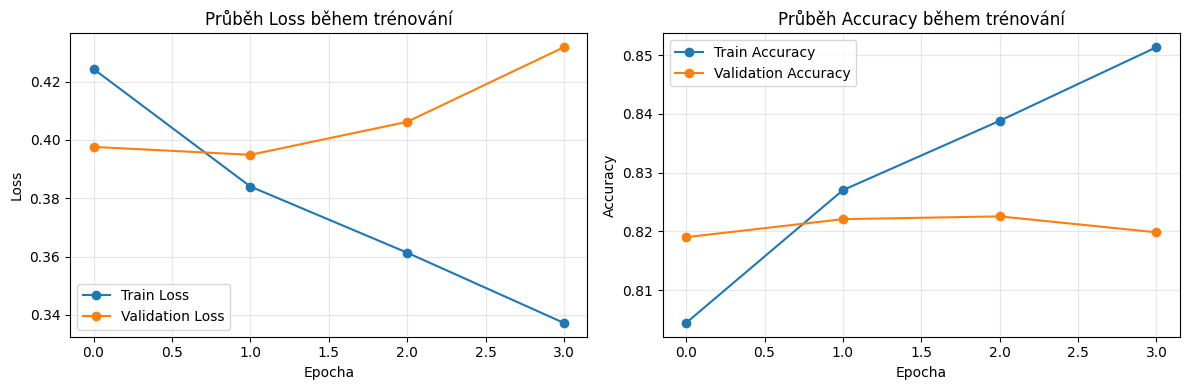


📊 Nejlepší epocha: 2
   Val Loss: 0.3949
   Val Accuracy: 0.8221


In [21]:
# Vizualizace průběhu trénování
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Graf Loss (ztráta)
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_title('Průběh Loss během trénování')
axes[0].set_xlabel('Epocha')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graf Accuracy (přesnost)
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[1].set_title('Průběh Accuracy během trénování')
axes[1].set_xlabel('Epocha')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Výpis nejlepších hodnot
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"\n📊 Nejlepší epocha: {best_epoch}")
print(f"   Val Loss: {history.history['val_loss'][best_epoch-1]:.4f}")
print(f"   Val Accuracy: {history.history['val_accuracy'][best_epoch-1]:.4f}")

In [22]:
# Vyhodnocení modelu na testovacích datech
print("🧪 Vyhodnocuji model na testovacích datech...")
print("=" * 50)

# Predikce na testovacích datech
y_pred_prob = model.predict(X_test, verbose=0)  # Pravděpodobnosti (0-1)

# Diagnostika - podíváme se na rozložení predikcí
print(f"\n🔍 Diagnostika predikcí:")
print(f"   Min pravděpodobnost: {y_pred_prob.min():.6f}")
print(f"   Max pravděpodobnost: {y_pred_prob.max():.6f}")
print(f"   Průměr: {y_pred_prob.mean():.6f}")
print(f"   Prvních 10 predikcí: {y_pred_prob[:10].flatten()}")

y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Převod na 0/1

print(f"\n   Počet predikovaných 0 (negativní): {(y_pred == 0).sum():,}")
print(f"   Počet predikovaných 1 (pozitivní): {(y_pred == 1).sum():,}")
print(f"   Skutečných 0: {(y_test == 0).sum():,}")
print(f"   Skutečných 1: {(y_test == 1).sum():,}")

# Výpočet metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n📊 Metriky na testovacích datech:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negativní', 'Pozitivní']))

🧪 Vyhodnocuji model na testovacích datech...

🔍 Diagnostika predikcí:
   Min pravděpodobnost: 0.000102
   Max pravděpodobnost: 0.999837
   Průměr: 0.506619
   Prvních 10 predikcí: [0.13914058 0.94558746 0.95437056 0.8622673  0.98614687 0.986368
 0.55899125 0.85580355 0.72008294 0.82576114]

   Počet predikovaných 0 (negativní): 79,015
   Počet predikovaných 1 (pozitivní): 80,985
   Skutečných 0: 80,000
   Skutečných 1: 80,000

📊 Metriky na testovacích datech:
   Accuracy:  0.8241 (82.41%)
   Precision: 0.8201
   Recall:    0.8302
   F1-Score:  0.8251

📋 Classification Report:
              precision    recall  f1-score   support

   Negativní       0.83      0.82      0.82     80000
   Pozitivní       0.82      0.83      0.83     80000

    accuracy                           0.82    160000
   macro avg       0.82      0.82      0.82    160000
weighted avg       0.82      0.82      0.82    160000



In [ ]:
# Pokus o načtení uloženého modelu (pokud existuje)
import os

# Použijeme stejnou cestu jako při trénování
if IN_COLAB:
    model_path = '/content/drive/My Drive/xdeep-sentiment/models/sentiment_lstm_model.keras'
else:
    model_path = 'models/sentiment_lstm_model.keras'

if os.path.exists(model_path):
    print(f"✅ Nalezen uložený model: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model úspěšně načten!")

    model.summary()    
    print("⚠️ Spusť nejprve trénování (buňka 28).")

else:    print(f"❌ Model nebyl nalezen: {model_path}")


❌ Model nebyl nalezen: /content/drive/MyDrive/xdeep-sentiment/models/sentiment_lstm_model.keras


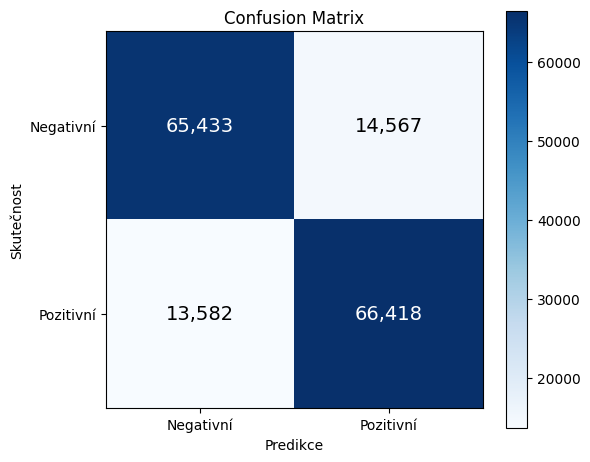


📊 Interpretace Confusion Matrix:
   ✅ True Negatives (správně negativní):  65,433
   ❌ False Positives (falešně pozitivní): 14,567
   ❌ False Negatives (falešně negativní): 13,582
   ✅ True Positives (správně pozitivní):  66,418


In [24]:
# Vizualizace Confusion Matrix (matice záměn)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Popisky
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Negativní', 'Pozitivní'])
ax.set_yticklabels(['Negativní', 'Pozitivní'])
ax.set_xlabel('Predikce')
ax.set_ylabel('Skutečnost')
ax.set_title('Confusion Matrix')

# Přidání hodnot do buněk
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{cm[i, j]:,}', ha='center', va='center', 
                       color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)

plt.colorbar(im)
plt.tight_layout()
plt.show()

# Interpretace
print(f"\n📊 Interpretace Confusion Matrix:")
print(f"   ✅ True Negatives (správně negativní):  {cm[0,0]:,}")
print(f"   ❌ False Positives (falešně pozitivní): {cm[0,1]:,}")
print(f"   ❌ False Negatives (falešně negativní): {cm[1,0]:,}")
print(f"   ✅ True Positives (správně pozitivní):  {cm[1,1]:,}")

## 8. Inference pro nové texty

Vytvoříme funkci, která umožní predikovat sentiment pro libovolný nový text.

In [25]:
def predict_sentiment(text, model=model, tokenizer=tokenizer, max_length=MAX_LENGTH):
    """
    Predikuje sentiment pro daný text.
    
    Args:
        text: Text k analýze (string)
        model: Natrénovaný model
        tokenizer: Tokenizer použitý při trénování
        max_length: Maximální délka sekvence
        
    Returns:
        dict s predikcí, pravděpodobností a interpretací
    """
    # Vyčištění textu (stejná funkce jako při trénování)
    cleaned = clean_text(text)
    
    # Tokenizace
    sequence = tokenizer.texts_to_sequences([cleaned])
    
    # Padding - MUSÍ být stejný jako při trénování (padding='pre')
    padded = pad_sequences(sequence, maxlen=max_length, padding='pre', truncating='post')
    
    # Predikce
    probability = model.predict(padded, verbose=0)[0][0]
    sentiment = 'Pozitivní 😊' if probability > 0.5 else 'Negativní 😠'
    confidence = probability if probability > 0.5 else 1 - probability
    
    return {
        'text': text,
        'cleaned': cleaned,
        'sentiment': sentiment,
        'probability': probability,
        'confidence': confidence * 100
    }

print("✅ Funkce predict_sentiment() je připravena!")

✅ Funkce predict_sentiment() je připravena!


In [28]:
# Testování na vlastních textech
test_texts = [
    "I absolutely love this product! Best purchase ever!",
    "This is terrible. Waste of money. Never buying again.",
    "The weather is nice today.",
    "I'm so excited about the weekend trip!",
    "My flight was cancelled and I'm stuck at the airport.",
    "Just had an amazing dinner with friends!",
    "This movie was boring and predictable.",
    "This was the best night of my life. But on the other hand, it was the worst night of my life."
]

print("🔮 Testování modelu na nových textech:")
print("=" * 60)

for text in test_texts:
    result = predict_sentiment(text)
    print(f"\n📝 \"{text[:50]}{'...' if len(text) > 50 else ''}\"")
    print(f"   → {result['sentiment']} (jistota: {result['confidence']:.1f}%)")

🔮 Testování modelu na nových textech:

📝 "I absolutely love this product! Best purchase ever..."
   → Pozitivní 😊 (jistota: 99.2%)

📝 "This is terrible. Waste of money. Never buying aga..."
   → Negativní 😠 (jistota: 96.2%)

📝 "The weather is nice today."
   → Pozitivní 😊 (jistota: 96.5%)

📝 "I'm so excited about the weekend trip!"
   → Pozitivní 😊 (jistota: 98.6%)

📝 "My flight was cancelled and I'm stuck at the airpo..."
   → Negativní 😠 (jistota: 99.4%)

📝 "Just had an amazing dinner with friends!"
   → Pozitivní 😊 (jistota: 99.8%)

📝 "This movie was boring and predictable."
   → Pozitivní 😊 (jistota: 51.7%)

📝 "This was the best night of my life. But on the oth..."
   → Negativní 😠 (jistota: 81.6%)


## 9. Uložení modelu

Uložíme natrénovaný model pro pozdější použití.

In [ ]:
# Uložení modelu a tokenizeru (na Google Drive pro perzistenci)
import pickle
import os

# Použijeme stejnou cestu jako při trénování
if IN_COLAB:
    save_dir = '/content/drive/My Drive/xdeep-sentiment/models'
else:
    save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

# Uložení Keras modelu (nativní formát)
model_path = os.path.join(save_dir, 'sentiment_lstm_model.keras')
model.save(model_path)
print(f"✅ Model uložen: {model_path}")

# Uložení tokenizeru (potřebujeme ho pro inference)
tokenizer_path = os.path.join(save_dir, 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer uložen: {tokenizer_path}")

# Uložení konfigurace
config = {
    'VOCAB_SIZE': VOCAB_SIZE,
    'MAX_LENGTH': MAX_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM
}
config_path = os.path.join(save_dir, 'config.pkl')
with open(config_path, 'wb') as f:
    pickle.dump(config, f)

print(f"✅ Konfigurace uložena: {config_path}")
print("💡 Tyto soubory přežijí restart Colab runtime!")

print(f"\n📁 Všechny soubory jsou na Google Drive: {save_dir}/")


✅ Model uložen: /content/drive/MyDrive/xdeep-sentiment/models/sentiment_lstm_model.keras
✅ Tokenizer uložen: /content/drive/MyDrive/xdeep-sentiment/models/tokenizer.pkl
✅ Konfigurace uložena: /content/drive/MyDrive/xdeep-sentiment/models/config.pkl
💡 Tyto soubory přežijí restart Colab runtime!

📁 Všechny soubory jsou na Google Drive: /content/drive/MyDrive/xdeep-sentiment/models/


## Shrnutí

Úspěšně jsme vytvořili model pro analýzu sentimentu! 

**Co jsme se naučili:**
- Načítání a předzpracování textových dat
- Tokenizace a padding sekvencí
- Vytvoření a trénování LSTM modelu
- Vyhodnocení pomocí metrik a confusion matrix
- Inference pro nové texty

**Možná vylepšení:**
- Použít `padding='pre'` místo `'post'` (lepší pro LSTM)
- Přidat `Bidirectional(LSTM(...))` pro obousměrné zpracování
- Experimentovat s jinými architekturami (GRU, Transformer)
- Fine-tuning na specifické doméně